# Support Vector Machines 2020, 2022
### Oswin Krause, Christian Igel

Some general stuff first:

In [1]:
%matplotlib inline
import numpy as np
import math

from sklearn import svm
from sklearn.datasets import make_classification, make_moons, make_circles
import sklearn.metrics.pairwise as kernels  

from matplotlib.collections import LineCollection
import matplotlib.transforms as mtransforms

import ipywidgets as widgets

import matplotlib as mpl
import matplotlib.pyplot as plt
# Default figure size in inches
plt.rcParams['figure.figsize'] = (14.0, 10.0)

Definition of interactive SVMs in for two- and one-dimensioanl inputs: 

In [2]:
def plot_interactive_SVM(X, y, res=None):
    """
    Create an interactive SVM plot. Set 'res' to a low value for a finer
    grid (i.e. higher resolution of the background).
    """
    
    xl, xh = np.floor(X[:,0].min() - 0.1), np.ceil(X[:,0].max() + 0.1)
    yl, yh = np.floor(X[:,1].min() - 0.1), np.ceil(X[:,1].max() + 0.1)

    class_colours = ['b' if i==0 else 'r' for i in y]
    
    if res is None:
        res = (xh-xl)/300
    
    # Create grid to calculate the decision boundary on:
    xx, yy = np.meshgrid(np.arange(xl, xh, res),
                         np.arange(yl, yh, res))

    
    def f(C, gamma, degree, kernel):    
        def expKernel(X,Y):
            K = np.dot(X, Y.T)
            return np.exp(10**gamma * K)
        
        if kernel== "exponential":
            kernel = expKernel
        
        clf = svm.SVC(C=10**C, gamma=10**gamma, kernel=kernel, degree=degree, coef0=1.0, shrinking=False)
        clf.fit(X, y)

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
                 
        plt.figure(42)
        ax = plt.gca()
        
        # Plot data
        ax.scatter(X[:,0], X[:,1], s=45, c=class_colours,
                   edgecolor=mpl.cm.gray(.95), lw=0.5, zorder=100)

        # Plot image
        cax = ax.matshow(Z, cmap=mpl.cm.coolwarm, origin="lower", vmin=-1, vmax=1, 
                         extent=[xl, xh, yl, yh], aspect="auto", alpha=.4)
        plt.colorbar(cax)
        
        ax.contour(xx, yy, Z, levels=[-1,0,+1], colors=[mpl.cm.gray(.45), mpl.cm.gray(.24), mpl.cm.gray(.45)], 
                   linestyles=["dashed","solid","dashed"], linewidths=2)

        ax.xaxis.set_ticks_position('bottom')
        ax.grid(False)

        plt.xlim(xl, xh)
        plt.ylim(yl, yh)
        plt.show()

  
    _ = widgets.interact(f, 
                        kernel=widgets.RadioButtons(options=("linear", "poly", "rbf", "exponential")),
                        C=widgets.IntSlider(min=-5, max=10,
                                            step=1, value=0, description='log $C$', continuous_update=False),
                        gamma=widgets.IntSlider(min=-5, max=5,
                                                step=1, value=0, description='log $\gamma$', continuous_update=False),
                        degree=widgets.IntSlider(min=1, max=10,
                                                step=1, value=3, continuous_update=False), continuous_update=False)
    
   

In [3]:
def plot_interactive_SVM1d(X, y, res=None):
    """
    Create an interactive SVM plot. Set 'res' to a low value for a finer
    grid (i.e., higher resolution of the background).
    """
    xl, xh = X[:,0].min() - 0.1, X[:,0].max() + 0.1
    
    if res is None:
        res = (xh-xl)/600
    
    # Create x-values to calculate the decision boundary on
    x_grid = np.arange(xl, xh, res)
    
    def f(log10_C, log10_gamma, degree, kernel):       
        #
        # Train SVM
        #
        clf = svm.SVC(C=10**log10_C, gamma=10**log10_gamma, kernel=kernel, degree=degree, coef0=1.0, shrinking=False)
        clf.fit(X, y)
        
        #
        # Set up plot
        #
        plt.figure(42)
        ax = plt.gca()
        ax.xaxis.set_ticks_position('bottom')
        ax.grid(False)
        plt.xlim(xl, xh)
        plt.xlabel("scalar input")
        plt.ylabel("decision function")

        # Use data coordinates for the x-axis and the axes coordinates for the y-axis'
        # Thus, y-ccordinates between 0 and 1 are from bottom top top
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

        #
        # Plot data
        #
        X_p=X[y==1]  # Positive points
        X_n=X[y==0]  # Negative points

        plt.plot(X_p, np.zeros(len(X_p)), '.', X_n, np.zeros(len(X_n)), '.', markersize=30)  # Plot points
       
        Z = clf.decision_function(x_grid.reshape(-1,1))  # Evaluate SVM decision functionm
        plt.plot(x_grid, Z, linewidth=4)  # Plot decision function

        #
        # Plot zero line and lines at 1 and -1
        #
        ax.axhline(1, lw=2, alpha=0.5, c=mpl.cm.gray(.45), linestyle="dashed")
        ax.axhline(-1, lw=2, alpha=0.5, c=mpl.cm.gray(.45), linestyle="dashed")
        ax.axhline(0, lw=2, alpha=0.5, c=mpl.cm.gray(.45))
        
        #
        # Shade positively and negativly classified regions
        #         
        xra = np.c_[x_grid[:-1], np.diff(x_grid)]
        ax.broken_barh(xra[Z[:-1] < 0,:], (0,1), facecolors='darkorange', alpha=0.5, transform=trans)
        ax.broken_barh(xra[Z[:-1] >= 0,:], (0,1), facecolors='cornflowerblue', alpha=0.5, transform=trans)  
   
        #
        # Plot individual kernel contributions
        #
        support_vector_indices = clf.support_  # Indices of support vectors
        alphas = clf.dual_coef_  # Coefficients (signed) of support vectors
        svs = X[support_vector_indices]  # Support vectors
        svs_alphas = np.column_stack((svs, alphas.reshape(-1,1)))  # Link support vectors and coefficients
        
        if(kernel=='rbf'):
            lines = [np.column_stack((x_grid,
                                      a*kernels.rbf_kernel(x_grid.reshape(-1,1), [[sv]], 
                                                           gamma=10**log10_gamma))) 
                     for sv, a in svs_alphas]
        if(kernel=='poly'):
            lines = [np.column_stack((x_grid,
                                      a*kernels.polynomial_kernel(x_grid.reshape(-1,1), [[sv]], 
                                                                  degree=degree, coef0=1.0, gamma=10**log10_gamma))) 
                     for sv, a in svs_alphas]
        if(kernel=='linear'):
            lines = [np.column_stack((x_grid,
                                      a*kernels.linear_kernel(x_grid.reshape(-1,1), [[sv]]))) 
                     for sv, a in svs_alphas]
        line_collection = LineCollection(lines, linestyle='dashed', color=mpl.cm.gray(.65))
        ax.add_collection(line_collection)
                 
        #
        # Show plot
        #
        plt.show()
        print("b:", *clf.intercept_)
        print("SVs:", support_vector_indices)
        print("coeff.:", clf.dual_coef_)
        print("[SV x, coeff.]:",svs_alphas)

    _ = widgets.interact(f, 
                        kernel=widgets.RadioButtons(options=("linear", "poly", "rbf")),
                        log10_C=widgets.IntSlider(min=-5, max=10, step=1, value=0, description='$\log_{10} C$'),
                        log10_gamma=widgets.IntSlider(min=-5, max=5,
                                                step=1, value=2, description='$\log_{10} \gamma$'),
                        degree=widgets.IntSlider(min=1, max=10,
                                                step=1, value=3))

## Kernels

Kernels correspond to an inner-product in feature space, $k(x,z)=\langle \phi(x), \phi(z) \rangle$. We consider models, kernel expansions, of the form $f(x)=\sum_{i=1}^\ell \alpha_i k(x^{(i)},x)$.

First, we will visualize models for different kernels in 1D.

**Exercise:** Play around with some kernels and visualize the resulting functions. Get a feeling for what the hyperparameters of the kernels are doing.

In [4]:
gamma_par = 2.5
degree_par = 3.0
offset_par=0.1

# Standard kernels
def gaussian_kernel(x,z): # hyperparameter gamma
    return math.exp(-gamma_par*(x-z)**2)
def laplace_kernel(x,z): # hyperparameter gamma
    return math.exp(-gamma_par*abs(x-z))
def polynomial_kernel(x,z): # hyperparameters degree and offset
    return (x*z+offset_par)**degree_par
def exponential_kernel(x,z): # hyperparameter gamma
    return exp(gamma_par*x*z)
def sinc_kernel(x,z): # hyperparameter gamma
    return sin(gamma_par**2 *(x-z))/(gamma_par**2 *(x-z))
# Other kernels and kernel combinations
# There are many more ways to create and combine kernels
# We can always normalize a kernel so that k(x,x)=1
def normalized_polynomial_kernel(x,z): # Note: offset should be > 0
    return polynomial_kernel(x,z) / math.sqrt(polynomial_kernel(x,x)*polynomial_kernel(z,z))
# We can also multiply kernels
def multiplied_kernel(x,z):
    return sinc_kernel(x,z) * polynomial_kernel(x,z)
# Adding kernels is also fine
def added_kernel(x,z):
    return laplace_kernel(x,z) + gaussian_kernel(x,z)
# Given a kernel k(x,z) and a function g, than scaling the kernel by g,
# g(k(x,z)) is a kernel if g and all its derivatives are >=0  (Taylor expansion has only positive coefficients)
# An example is g=exp
def scaled_kernel(x,z):
    return math.exp(laplace_kernel(x,z))

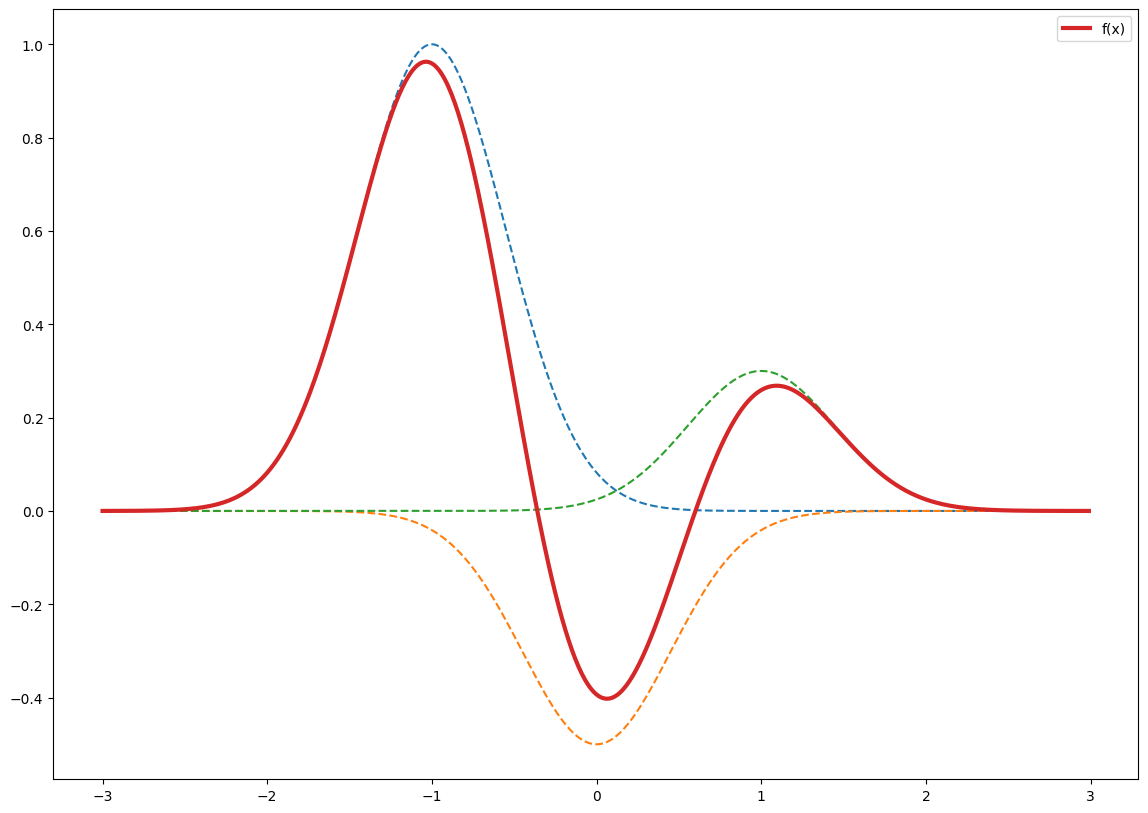

In [5]:
# Function to visualize a kernel k, choose some of the above
def visualize_kernel(k, alpha0, alpha1, alpha2, maxPlot):
    X = np.arange(-maxPlot, maxPlot, 0.01)
    xbase=[-1,0.0,1] # Feel free to change the basis points as well
    f = lambda x: alpha0*k(xbase[0],x)+ alpha1*k(xbase[1],x) + alpha2*k(xbase[2],x)
    y0=[alpha0*k(xbase[0],x) for x in X]
    y1=[alpha1*k(xbase[1],x) for x in X]
    y2=[alpha2*k(xbase[2],x) for x in X]
    y=[f(x) for x in X]
    plt.figure(42)
    plt.plot(X, y0, X, y1, X, y2, linestyle="dashed")
    plt.plot(X,y, label='f(x)', lw=3)
    plt.legend()
    plt.show()
    
# Try to choose different kernel functions from the set above.
# Use the maxPlot setting to narrow down the plotting area for very fast growing kernels.
# visualize_kernel(multiplied_kernel, 1,1,1, maxPlot=3)
visualize_kernel(gaussian_kernel, 1, -0.5, .3, maxPlot=3)

## SVM in 1D

Now, let's train an SVM and see how changing the kernel and the complexity parameter changes the function. We generate a simple dataset by taking samples from two gaussian distributions - one for each class. Afterwards, we want an SVM to learn the classes. If the response of the final model is bigger than 0, we predict class 1, otherwise we predict class -1. 

We consider models of the form $f(x)=\sum_{i=1}^\ell \alpha_i k(x^{(i)},x) + b$, that is, we add an offset/bias parameter.

The background colors indicate where the scalar input is assigned to class 1 and -1, respectively.
The dashed lines plot $\alpha_i k(x^{(i)},x)$ for all training points $x^{(i)}$. Remember to also consider the offset parameter $b$, which is printed below the figure, when interpreting the plot.

(Be a bit careful with large values of C, the solver used here can take a long time to converge.)

**Exercise:** Can you see when a correctly classified point violates the margin? 

In [ ]:
X1, y1 = make_classification(n_samples=10, n_features=1, n_informative=1, n_redundant=0, n_clusters_per_class=1, class_sep=0.5, random_state=1)
plot_interactive_SVM1d(X1, y1)

interactive(children=(IntSlider(value=0, description='$\\log_{10} C$', max=10, min=-5), IntSlider(value=2, des…

interactive(children=(IntSlider(value=0, description='$\\log_{10} C$', max=10, min=-5), IntSlider(value=2, des…

## SVM in 2D

Next, we move from simple 1D problems to 2D problems. The sliders below have the same effect on the SVM as above, however, we are now in 2D which requires a different way to visualize the function. The decision boundary is the black line, the grey dashed lines indicate the margins. Function values are shown color coded, truncated at 1 and -1. Thus, color can be interpreted as class-likelihood. 

**Exercise:** Play around with the models and try to get a feeling for how the model behaves. Ask yourself: Are the values of C and the other parameters independent? Does it make sense to compare the C values of SVMs with different kernels? Or keep a value of C and change the kernels?

(Be a bit careful with large values of C, the solver used here can take a long time to converge.)

In [ ]:
# Imports you might need
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold

X, y = load_breast_cancer(return_X_y = True)


In [ ]:
Xc, yc = make_circles(n_samples=50, noise=.2, factor=0.5, random_state=1)
plot_interactive_SVM(Xc, yc)

interactive(children=(IntSlider(value=0, continuous_update=False, description='log $C$', max=10, min=-5), IntS…

## Exercise

We want to solve a binary classification task. The right way to do it with an SVM is to create a training-test split and then perform cross-validation on the training split to find the right hyper-parameters (C and parameters of the kernel).

For this task we choose a Gaussian kernel and SVM to learn the breast-cancer dataset. Try to implement the program on your own with the help of the links provided to the documentation.

Cross-validation is a technique where the training set is split in k parts of equal size. After splitting, k models with the same setting of the hyper-parameters are trained. For each of the models, one part of the dataset is removed (thus only k-1 parts are used for actual training) and the removed part is used as a validation set. The average over the errors on all validation sets is then used to select the best setting for the hyperparameters. This average is called the "cross-validation error". The best hyperparameters found in the cross-validation procedure are then used to train the SVM on the full training data set.

We want to perform cross-validation on an SVM with Gaussian kernel, therefore we have two parameters to tune: $C$ and $\gamma$. We consider $C=0.01,0.1,1,10,1000$ and $\gamma=0.1,1,10$ and search in a grid of all those combinations. For each combination the cross-valdiation error is computed.

There are two ways to compute this with sklearn: write your own for-loops over the grid and compute the cross-validation error or use the GridSearchCV object. In this assignment it would be good to implement it both ways. First implement it yourself using for-loops and the KFold class and afterwards use the GridSearchCV implementation in sklearn.

Here a few guides to structure your work:
* Step 1: Load the data and perform training-test split
* Important optional step: normalize your data to zero-mean unit variance! (se the StandardScaler API for training and test) (Q: Why is this a good idea for a Gaussian kernel?)
* Step 2: Setup the search grid
* Step 3: Loop over the grid and Train an SVM for each point in the grid
* Intermediate step: calculate test error when training using the complete training set
* Step 4: Implement cross-validation for each point and compute the error on the validation set
* Step 5: Pick the hyper-parameter with the best cross-validation error
* Step 6: Train the SVM with this hyper-parameter on the full training set
* Step 7: Compute the test error on the final model


The documentation can be found here:

Scaling of dataset: http://scikit-learn.org/stable/modules/preprocessing.html

SVM for classification: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

Create the cross-validation subsets: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

Grid-Search: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

Compute validation and test error: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

